# Example: Analysis of a Cash Secured Put Position in AMD
In this example, we analyze the behavior and properties of a cash secured put option, which behaves like a short put option position in combination with a cash position equal to the strike price of the put option contract.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Construct profit diagrams for cash secured put positions:__ Build profit and loss profiles for short put contracts by computing payoff and profit functions, and determine the breakeven point where the position transitions from profit to loss.
> * __Calculate probability of outcomes using cumulative distributions:__ Use cumulative distribution functions of projected share price distributions to determine the likelihood of downside loss, maximum profit, and exercise scenarios for cash secured put positions at expiration.
> * __Compare exercise probability with Delta:__ Evaluate the relationship between the computed probability of exercise using share price distributions and the Delta of the put contract as a probability estimate.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [52]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the metadata in the `metadata::Dict{String,Any}` variable and the options chain data in the `optionschain::DataFrame` variable.

In [53]:
metadata, optionschain, ticker = let
    
    # initialize -
    ticker = "amd";
    options_dataset = MyOptionsChainDataSet(ticker = ticker);
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain, ticker) # return
end;

What's in the `metadata::Dict{String,Any}` dictionary? 

In [54]:
let

    # initialize -
    df = DataFrame();
    fields = metadata |> keys |> collect |> sort;

    for i ∈ eachindex(fields)
        field = fields[i];
        row_df = (
            field = field |> String,
            value = metadata[field] |> string,
        );
        push!(df, row_df);
    end

    # make a table -
    pretty_table(
         df;
         fit_table_in_display_horizontally = false,
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );

end

 ---------------------------- --------------
                       field          value 
                      String         String 
 ---------------------------- --------------
                         DTE             58
                      atm_IV         0.5903
             expiration_date     2025-12-19
       historical_volatility         0.7971
                   is_weekly          false
               purchase_date     2025-10-22
                      source   barchart.com
  underlying_share_price_ask         225.91
  underlying_share_price_bid         225.74
  underlying_share_price_mid         225.78
 ---------------------------- --------------


What about the `optionschain::DataFrame` variable?

In [55]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


In [56]:
let
        
        # initialize -
        δ = 0.5; # set the delta for ATM search
        options_chain = optionschain;
        Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

        # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
        atm_put_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, options_chain);
        
        # return -
        atm_put_options;
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,115.0,0.4972,114.4,114.98,115.55,121.33,0,"3,187",0.8688,0.9853,Call
2,120.0,0.4754,109.65,110.1,110.55,109.75,1,"5,468",0.7294,0.9915,Call
3,125.0,0.4535,104.65,105.2,105.75,105.85,10,"5,090",0.8135,0.9796,Call
4,130.0,0.4317,99.9,100.35,100.8,98.6,2,"3,540",0.7909,0.9756,Call
5,135.0,0.4098,95.25,95.65,96.05,96.69,4,"3,604",0.7897,0.9681,Call
6,140.0,0.388,90.25,90.7,91.15,92.35,46,"4,005",0.7459,0.9658,Call
7,145.0,0.3661,85.45,85.93,86.4,85.15,33,"2,295",0.7261,0.9593,Call
8,150.0,0.3442,80.75,81.23,81.7,79.6,92,"6,619",0.7115,0.9508,Call
9,155.0,0.3224,76.2,76.55,76.9,77.8,3,"4,606",0.6951,0.9415,Call


### Constants
Let's set a value for the step size `Δt::Float64`, i.e., `1 day` in units of years (assuming a `365-day` year), and the risk-free rate at the time we gathered the data for the option contracts; we approximate this value using the [yield on the 10-year Treasury Note](https://ycharts.com/indicators/10_year_treasury_rate). We also set a value for the underlying share price `Sₒ::Float64`, the number of levels in the binomial tree model `h::Int64`, and the direction parameter `θ::Int64`.

In [57]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x); # mid underlying price on purchase date, 10-22-2025

Other constants:

In [58]:
Δt = (1/365); # options use 365 day year
DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 8*DTE |> x-> floor(Int, x); # 8-points per day
w = 0.3; # width parameter
θ = -1; # long/short indicator: -1 = short, +1 = long

___

## Task 1: Select a random put option from the dataset
In this task, we'll select put option contracts such that $\left(1-w\right)\cdot{S}_{\circ}\leq{K}<S_{\circ}$ where $w>0$, and we hold a long cash position equal to the strike price of the put option contract. 

Let's begin by filtering the contracts in the `optionschain::DataFrame` to include only `put` contracts that obey the strike price constraint. 
We'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the filtered selection of put contracts in the `put_contracts::DataFrame` variable:

In [59]:
put_contracts = filter(:Type=>x->x == "Put", optionschain) |> y -> filter(:Strike=> x-> (x < Sₒ && x ≥ (1-w)*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,160.0,-0.3005,1.97,1.99,2.01,2.04,200,"4,264",0.6674,-0.0669,Put
2,165.0,-0.2787,2.4,2.42,2.44,2.34,128,"2,901",0.6553,-0.0801,Put
3,170.0,-0.2568,2.92,2.95,2.97,3.1,90,"2,864",0.6447,-0.0956,Put
4,175.0,-0.2349,3.55,3.6,3.65,3.75,27,"2,572",0.6366,-0.114,Put
5,180.0,-0.2131,4.3,4.35,4.4,4.5,164,"10,797",0.628,-0.1343,Put
6,185.0,-0.1912,5.2,5.25,5.3,5.25,112,"1,744",0.6211,-0.1575,Put
7,190.0,-0.1694,6.2,6.28,6.35,6.35,235,"2,770",0.6171,-0.1838,Put
8,195.0,-0.1475,7.4,7.48,7.55,7.58,643,"6,688",0.6082,-0.2109,Put
9,200.0,-0.1256,8.8,8.88,8.95,8.88,"1,714","8,163",0.6041,-0.2415,Put


Select a random contract from the `put_contracts::DataFrame` collection; this will be our put leg of the cash-secured put. Save the data for this contract in the `put_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [60]:
put_leg_data = nrow(put_contracts) |> i-> put_contracts[rand(1:i),:] # fancy!

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
2,165.0,-0.2787,2.4,2.42,2.44,2.34,128,"2,901",0.6553,-0.0801,Put


Next, build a [`MyAmericanPutContractModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the `put` contract data and store this contract model in the `put_contract_model::MyAmericanPutContractModel` variable. 

To access data from the `DataFrameRow`, pass in the column name. For example, to get the strike price, you would say: `put_leg_data[:Strike]`. For the premium value, use the midpoint value.

In [61]:
put_contract_model = build(MyAmericanPutContractModel, (
    K = put_leg_data[:Strike], 
    premium = put_leg_data[:Mid], # mark price
    IV = put_leg_data[:IV], # implied volatility in percentage
    DTE = (DTE)*Δt,
    sense = θ, # compute greeks of long contract
    copy = 1,
)); 

___

## Task 2: Compute the breakeven point for short put contract
In this task, let's begin by computing the breakeven of the `put` contract we constructed above. The payoff per share at expiration for a `put` option contract is given by:
$$
\begin{align*}
V_{p}(K,S(T)) = \max\left(K - S(T),~0\right)
\end{align*}
$$
where $K$ denotes the strike price and $S(T)$ is the share price at expiration. The `seller` charges the `buyer` a premium $\mathcal{P}_{p}(K, S(0))$ for each contract. Because we sold this contract, we are in a short position. For the general case, the profit for a put contract is given by:
$$
\begin{equation*}
P_{p}(K,S(T)) = \theta\cdot\left({V_{p}}(K,S(T)) - \mathcal{P}_{p}(K,S(0))\right)
\end{equation*}
$$
where $\theta$ is a direction parameter; $\theta = 1$ if we are `long` the contract, while $\theta = -1$ if we are `short` the contract. The breakeven at expiration for both a long or short put contract is the share price $B_{p}(T)$ at expiration such that $P_{p}(K, B_{p}(T)) = 0$. Thus, for our short `AMD` put, the breakeven share price $B_{p}(T)$ USD/share would be:
$$
\begin{equation*}
B_{p} = K - \mathcal{P}_{p}(K,S(0))
\end{equation*}
$$
For the buyer to make money, the share price must fall below the breakeven price $B_{p}$. For the seller to make money, the share price must remain above the breakeven price. Compute the break-even price for the `put` contract and store this in the `computed_breakeven_price` variable:

In [62]:
computed_breakeven_price = put_contract_model.K - put_contract_model.premium;

### Visualize
Now that we have analytically computed the breakeven value, let's visualize the profit diagram at expiration for the cash secured put. To do this, build an array of share prices at expiration and save this in the `share_price_array::Array{Float64,1}` variable. 

We'll look at a range from $(1-w) \cdot B_{p}$ to $\left(2-w\right) \cdot S_{\circ}$, where $w$ is a width parameter $0<w<1$ that we specify.

In [63]:
share_price_array = let

    w = 0.95; # width of range to explore. Adjust me to see what happens
    number_of_steps = 1001; # leave me alone!
    K = put_contract_model.K; # strike price
    Bₚ = computed_breakeven_price; # breakeven price 

    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((w)*Bₚ, stop = (2-w)*Sₒ, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the short put. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments, the contract models as an array and the share price array.

The `profit_array` will be a `1001`$\times$ `3` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S(T)$ values, column `2` holds the profit for the short put, column `3` holds the overall profit for the composite trade.

In [64]:
profit_array = profit([put_contract_model], share_price_array)

1001×3 Matrix{Float64}:
 154.451  -8.129    -8.129
 154.534  -8.04638  -8.04638
 154.616  -7.96376  -7.96376
 154.699  -7.88115  -7.88115
 154.781  -7.79853  -7.79853
 154.864  -7.71591  -7.71591
 154.947  -7.63329  -7.63329
 155.029  -7.55067  -7.55067
 155.112  -7.46806  -7.46806
 155.195  -7.38544  -7.38544
   ⋮                
 236.408   2.42      2.42
 236.491   2.42      2.42
 236.573   2.42      2.42
 236.656   2.42      2.42
 236.739   2.42      2.42
 236.821   2.42      2.42
 236.904   2.42      2.42
 236.986   2.42      2.42
 237.069   2.42      2.42

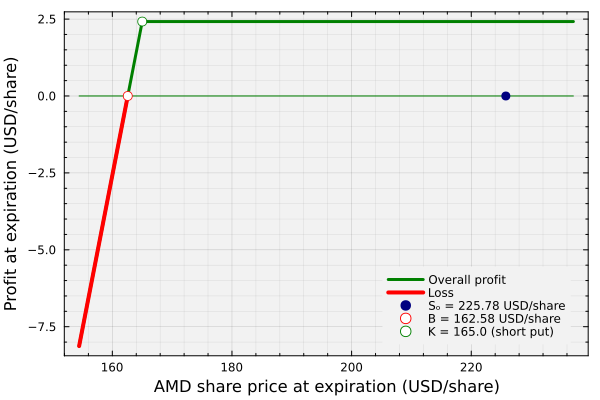

In [65]:
let
    # initialize 
    N = length(profit_array[:,1]); # how many steps do we have?
    BEL = zeros(N);
    K = put_contract_model.K;

    # SPL_vertical = range(-100,stop=100,length=N) |> collect;
    SPL_horizontal = Sₒ*ones(N);
    STRIKE_horizontal = K;
    max_profit = (put_contract_model.premium);
    B = computed_breakeven_price;

    # setup the coloring -
    profit_idx = findall(>(0), profit_array[:,end])
    # alternative_loss_index = findall(x->x ≥ max_profit_intersection, profit_array[:,end]);
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    plot(profit_array[:,1],profit_array[:,end], lw=3, c=:green, label="Overall profit", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legendfontsize=8, legend=:bottomright,
        xminorticks=5, yminorticks=5, minorgrid=true);
    plot!(profit_array[:,1], BEL, c=:green, lw=1, label="")
    plot!(loss_array[:,1], loss_array[:,3], lw=4, label="Loss", c=:red)
    scatter!([Sₒ], [0], ms=5, c=:navy, msc=:navy, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    scatter!([B], [0], ms=5, c=:white, msc=:red, ls=:dash, label="B = $(B) USD/share")
    scatter!([K],[max_profit], ms=5, label = "K = $(K) (short put)", msc=:green, c=:white)
    
    xlabel!("AMD share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit at expiration (USD/share)", fontsize=18)
end

___

## Task 3: Probability of Outcomes
In this task, we estimate the probability of certain outcomes for the cash-secured put position at expiration. We'll consider three scenarios:

> __Scenarios:__
>
> * __Scenario 1: Downside loss__. In this scenario, the share price at expiration $S(T)$ is at least $\epsilon$ _below_ the downside breakeven point $B$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S(T)\leq{B} - \epsilon) = F_{S}\left(B - \epsilon\right)$.
> * __Scenario 2: Maximum profit__. In this scenario, the share price at expiration $S(T)$ exceeds the strike price $K$. The probability of this scenario occurring is given by $P(S(T) > K) = 1 - F_{S}\left(K\right)$.
> * __Scenario 3: Exercise__. In this scenario, the share price at expiration $S(T)$ is less than or equal to the strike price $K$. The probability of this scenario occurring is given by $P(S(T) \leq K - \epsilon) = F_{S}\left(K - \epsilon\right)$, where $\epsilon \geq$ `0.01` USD/share.


To start, let's build a model of the future underlying share price at expiration $S(T)$. Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 

> __Risk-neutral pricing__: We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data. This gives us the risk-neutral simulation of the underlying share price at expiration.

We'll save the model in the `model::MyGeometricBrownianMotionEquityModel` variable, and the implied volatility value in the `σ̄::Float64` variable.

In [66]:
model, σ̄ = let

    # Step 1: get the implied volatility 
    σ̄ = put_leg_data[:IV];

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate,
        σ = σ̄
    ));

    model, σ̄
end;

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint_samples::Array{Float64,1}` variable.

So what do we get?

In [67]:
endpoint = let
    number_of_samples = 25000; # TODO: adjust me!
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model emits a LogNormal share price distribution. However, for this analysis, we'll use a Normal distribution based on implied volatility. Build a [Normal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) and save this in the `d_gbm` variable.

In [68]:
d_gbm = let

    # Build the GBM model for the endpoint data -
    # d_gbm = fit_mle(LogNormal, endpoint); # log normal -

    # Build the Normal model for the endpoint data -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    ATM_IV = metadata["atm_IV"] |> x-> parse(Float64, x); # atm IV on purchase date, 10-22-2025
    
    # build the Normal model -
    d = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(ATM_IV)*sqrt(DTE*Δt));
    d; # return
end

Normal{Float64}(μ=227.33162192473233, σ=53.12828738827033)

### Cumulative distribution
Next, estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the share price distribution. 
We can query the cumulative distribution function $F_{S}(\star)$ for the projected distribution `d_gbm` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

#### Visualize
`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `AMD` share price at contract expiration using the `d_gbm` model:

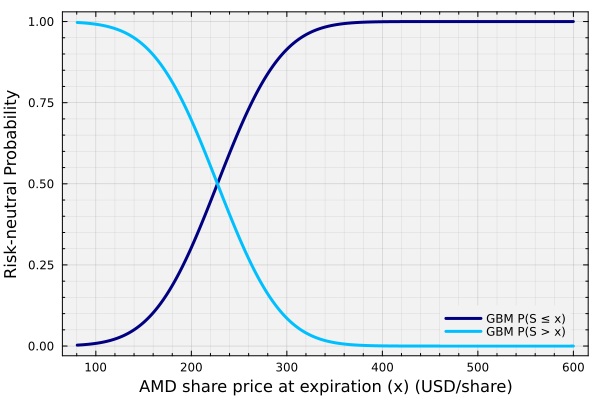

In [69]:
let
    number_of_samples = length(endpoint);
    X = Array{Float64,2}(undef, number_of_samples, 2);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint)
        push!(S,endpoint[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5, minorgrid=true,
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legendfontsize=8, legend=:bottomright)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)")

    xlabel!("AMD share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Risk-neutral Probability", fontsize=18);
end

Now that we have the cumulative distribution function for the share price distribution, let's compute the probability of observing each of the three scenarios outlined above.

> __Scenario 1: Downside loss__. In this scenario, the share price at expiration $S(T)$ is at least $\epsilon$ _below_ the downside breakeven point $B$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S(T)\leq{B} - \epsilon) = F_{S}\left(B - \epsilon\right)$.

Let's save the probability of this scenario occurring in the `p_downside_loss_gbm::Float64` variable.

In [70]:
p_downside_loss_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_downside_loss_gbm = nothing;
    B = computed_breakeven_price;

    # compute P(S < B_low -  ϵ) for the GBM model
    p_downside_loss_gbm = cdf(d_gbm,B-ϵ);

    # return data -
    p_downside_loss_gbm
end;

In [71]:
println("Scenario 1: Probability of downside loss = $(p_downside_loss_gbm)")

Scenario 1: Probability of downside loss = 0.11142838453084028


We've seen how to compute the probability of downside loss using the cumulative distribution function for the share price distribution. Next, let's compute the probability of maximum profit.

> __Scenario 2: Maximum profit__. In this scenario, the share price at expiration $S(T)$ exceeds the strike price $K$ by at least `+0.01` USD/share. The probability of this scenario occurring is given by $P(S(T) > K + \epsilon) = 1 - F_{S}\left(K + \epsilon\right)$.

We'll save the probability of this scenario occurring in the `p_max_profit_gbm::Float64` variable.

In [72]:
p_max_profit_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    K = put_contract_model.K

    # compute the probability P(S > K) for the GBM
    p_max_profit_gbm = 1 - cdf(d_gbm,K+ϵ);

    # return data -
    p_max_profit_gbm
end;

In [73]:
println("Scenario 2: Probability of max profit = $(p_max_profit_gbm)")

Scenario 2: Probability of max profit = 0.8796101764694173


Would we be better off holding the shares instead of selling the cash secured put? Let's compute the probability of exercise.

> __Scenario 3: Exercise__. In this scenario, the share price at expiration $S(T)$ is at least $\epsilon$ _below_ the strike price $K$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S(T) \leq K - \epsilon) = F_{S}\left(K - \epsilon\right)$.

We'll save the probability of this scenario occurring in the `p_exercise_gbm::Float64` variable.

In [74]:
p_exercise_gbm = let
    
    ϵ = 0.01; # 1/100 USD
    p_exercise_gbm = nothing;
    K = put_contract_model.K

    # compute P(S ≤ K - ϵ) for the GBM model
    p_exercise_gbm = cdf(d_gbm,K-ϵ);

    # return data -
    p_exercise_gbm
end;

In [75]:
println("Scenario 3: Probability of exercise = $(p_exercise_gbm)")

Scenario 3: Probability of exercise = 0.12031436321194111


__Curious?__ How close is the exercise probability to the $\Delta$ of the put contract?

In [76]:
delta_long_put = let

    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = deepcopy(put_contract_model); # alias the contract model
    contract_model.sense = 1; # long put (we always compute greeks for long contracts)

    # call the greek function
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # return -
    greek_value;
end

-0.08499999999999996

## Summary
This example demonstrates how to construct and analyze a cash secured put position using options data and projected share price distributions.

> __Key Takeaways:__
>
> * __Cash secured puts have one breakeven point:__ The breakeven price equals the strike price minus the premium received. The position is profitable when the share price stays above this breakeven point at expiration. The maximum profit occurs when the share price exceeds the strike price.
> * __Probability of outcomes uses cumulative distribution functions:__ The probability of downside loss is calculated as the probability that the share price falls below the breakeven point. The probability of maximum profit is the probability that the share price exceeds the strike price. The probability of exercise is the probability that the share price falls below the strike price.
> * __Delta approximates exercise probability:__ The Delta of the put contract provides an estimate of the probability of exercise that can be compared with the probability computed from the cumulative distribution function of the projected share price distribution.

Understanding cash secured put positions enables traders to generate income while potentially acquiring shares at a lower price.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.